In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras import layers
from keras.layers import Embedding

import seaborn as sns
sns.set(style = 'whitegrid')

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('../Cleaning/Clean_Dataset.csv', encoding='UTF-8')

In [3]:
train = df[['Clean_Text','Stop_Words_Text', 'Stemmed_Text', 'indonlp_sentiment', 'Lexicon_Score']]

#### Data Preprocessing

In [4]:
data = df['Clean_Text'].values.tolist()

In [5]:
print(data[:5])

['cina dan as terus bersaing mengembangkan teknologi terbaru termasuk kali ini perusahaan di kedua negara berlomba lomba membangun dunia virtual atau metaverse', 'katanya mau metaverse tapi down melulu bagaimana mas zuck', 'mungkin facebook sudah berencana menjadi metaverse besar secara sudah menyiapkan diem sebagai stable currency mereka kalau memang pasti nanti pindah ke blokchain semua facebook masih menang banyak karena hanya memerlukan pembaruan teknologi penggunanya sudah banyak', 'bersaing dengan perusahaan kelas dunia untuk mencapai hal ini sektor publik dan swasta harus bersatu untuk membentuk ekosistem metaverse yang melibatkan teknologi ar vr dan xr dalam forum tersebut juga dibahas bagaimana mensukseskan platform ini dengan pasar konsumen', 'sama sama semoga selalu terhindar dari usaha tipu menipu di metaverse iya']


### Building a Model

#### Label Encoding of Output

In [6]:
import tensorflow as tf
labels = np.array(train['indonlp_sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

#### Tokenizing dan Padding

In [7]:
max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[    0     0     0 ...    29    43     1]
 [    0     0     0 ...    57   218  1485]
 [    0     0     0 ...  1555    10    45]
 ...
 [    0     0     0 ...  1002     5   438]
 [    0     0     0 ...  1914   751 14967]
 [    0     0     0 ...   195     2   630]]


#### Split Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32977, 100) (32977, 3)
(8245, 100) (8245, 3)


#### LSTM

In [9]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model

In [10]:
history = model2.fit(tweets, labels, epochs=10,validation_split=0.2)

Epoch 1/10
1031/1031 [==============================] - 82s 72ms/step - loss: 0.6849 - accuracy: 0.7065 - val_loss: 0.5561 - val_accuracy: 0.7839
Epoch 2/10
1031/1031 [==============================] - 73s 71ms/step - loss: 0.4764 - accuracy: 0.8089 - val_loss: 0.5113 - val_accuracy: 0.8019
Epoch 3/10
1031/1031 [==============================] - 76s 74ms/step - loss: 0.3753 - accuracy: 0.8534 - val_loss: 0.5428 - val_accuracy: 0.7905
Epoch 4/10
1031/1031 [==============================] - 80s 78ms/step - loss: 0.3152 - accuracy: 0.8770 - val_loss: 0.5589 - val_accuracy: 0.7989
Epoch 5/10
1031/1031 [==============================] - 83s 80ms/step - loss: 0.2713 - accuracy: 0.8978 - val_loss: 0.6146 - val_accuracy: 0.7932
Epoch 6/10
1031/1031 [==============================] - 82s 80ms/step - loss: 0.2394 - accuracy: 0.9095 - val_loss: 0.6224 - val_accuracy: 0.7925
Epoch 7/10
1031/1031 [==============================] - 78s 75ms/step - loss: 0.2199 - accuracy: 0.9162 - val_loss: 0.6911 -

1289/1289 [==============================] - 17s 13ms/step
Model Accuracy on Test Data: 0.9310319732181844


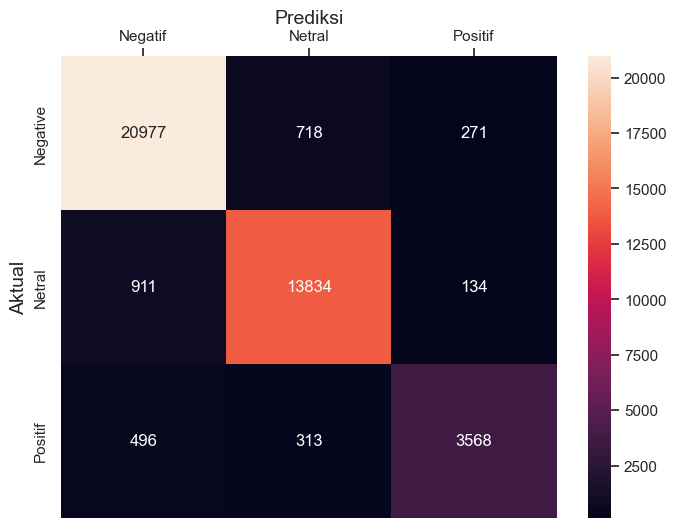

In [51]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model2.predict(tweets), axis=1)
y_true = np.argmax(labels, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediksi', fontsize=14)
ax.set_xticklabels(['Negatif', 'Netral', 'Positif'])
ax.set_ylabel('Aktual', fontsize=14)
ax.set_yticklabels(['Negative', 'Netral', 'Positif'])
plt.show()


In [52]:
# predict classes for test set
y_pred = np.argmax(model2.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


258/258 [==============================] - 3s 13ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4316
           1       0.93      0.93      0.93      3057
           2       0.90      0.82      0.86       872

    accuracy                           0.93      8245
   macro avg       0.92      0.90      0.91      8245
weighted avg       0.93      0.93      0.93      8245

[[4119  152   45]
 [ 177 2843   37]
 [  88   71  713]]


In [28]:
# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_int, y_pred)
precision = precision_score(y_test_int, y_pred, average='macro')
recall = recall_score(y_test_int, y_pred, average='macro')
f1 = f1_score(y_test_int, y_pred, average='macro')

In [29]:
# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))

Accuracy: 93.09%
Precision: 92.12%
Recall: 90.07%
F1-score: 91.03%


#### Prediksi dan Hasil

In [30]:
sentiment = ['Neutral', 'Negative', 'Positive']

In [31]:
sequence = tokenizer.texts_to_sequences(['metaverse teknologi yang sangat buruk'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 157ms/step


'Negative'

In [32]:
sequence = tokenizer.texts_to_sequences(['wow metaverse teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 52ms/step


'Positive'

In [33]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi tersebut'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 41ms/step


'Neutral'

#### Model dengan beberapa penyesuaian (Fine-Tuning)

In [19]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(15,dropout=0.5)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history2 = model.fit(tweets, labels, epochs=20,validation_split=0.2)

Epoch 1/20
1031/1031 [==============================] - 88s 77ms/step - loss: 0.7323 - accuracy: 0.6847 - val_loss: 0.6297 - val_accuracy: 0.7722
Epoch 2/20
1031/1031 [==============================] - 77s 74ms/step - loss: 0.5773 - accuracy: 0.7632 - val_loss: 0.5779 - val_accuracy: 0.7831
Epoch 3/20
1031/1031 [==============================] - 75s 73ms/step - loss: 0.5231 - accuracy: 0.7884 - val_loss: 0.5920 - val_accuracy: 0.7808
Epoch 4/20
1031/1031 [==============================] - 78s 75ms/step - loss: 0.4879 - accuracy: 0.8060 - val_loss: 0.5630 - val_accuracy: 0.7921
Epoch 5/20
1031/1031 [==============================] - 69s 67ms/step - loss: 0.4609 - accuracy: 0.8179 - val_loss: 0.6176 - val_accuracy: 0.7871
Epoch 6/20
1031/1031 [==============================] - 51s 49ms/step - loss: 0.4396 - accuracy: 0.8284 - val_loss: 0.5977 - val_accuracy: 0.7907
Epoch 7/20
1031/1031 [==============================] - 51s 50ms/step - loss: 0.4165 - accuracy: 0.8360 - val_loss: 0.5811 -

258/258 [==============================] - 3s 13ms/step
Model Accuracy on Test Data: 0.8864766525166767


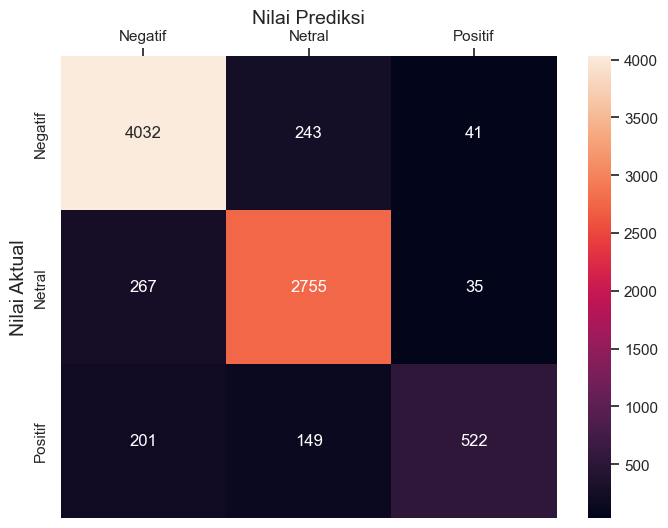

In [54]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Nilai Prediksi', fontsize=14)
ax.set_xticklabels(['Negatif', 'Netral', 'Positif'])
ax.set_ylabel('Nilai Aktual', fontsize=14)
ax.set_yticklabels(['Negatif', 'Netral', 'Positif'])
plt.show()


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# predict classes for test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


258/258 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4316
           1       0.88      0.90      0.89      3057
           2       0.87      0.60      0.71       872

    accuracy                           0.89      8245
   macro avg       0.88      0.81      0.84      8245
weighted avg       0.89      0.89      0.88      8245

[[4032  243   41]
 [ 267 2755   35]
 [ 201  149  522]]


In [43]:
def sentiment_predict(text):
    sequence = tokenizer.texts_to_sequences(text)
    test = pad_sequences(sequence, maxlen=max_len)
    return sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
df['LSTM_Predict_Sentiment'] = df['Clean_Text'].apply(lambda x: sentiment_predict(x))

In [45]:
sequence = tokenizer.texts_to_sequences(['metaverse itu bahasa yahudinya aku cinta israel'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 106ms/step


'Neutral'

In [48]:
sequence = tokenizer.texts_to_sequences(['itu kategori metaverse ya yang menang lalisa takes over vmas'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 36ms/step


'Negative'

In [44]:
sequence = tokenizer.texts_to_sequences(['teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 209ms/step


'Positive'

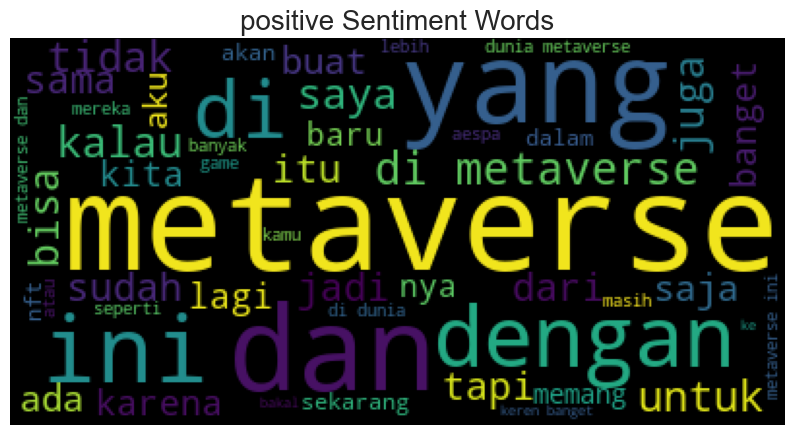

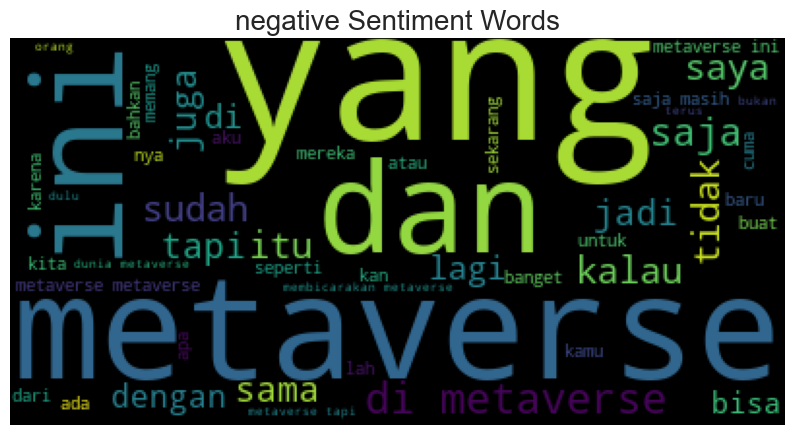

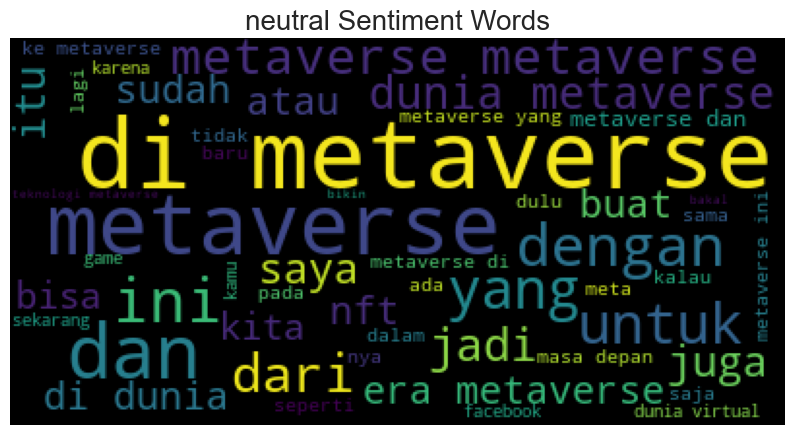

In [58]:
# Visualizing data into Wordclouds

from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, indonlp_sentiment):
    combined_tweets = " ".join([tweet for tweet in df[df.indonlp_sentiment==indonlp_sentiment]['Clean_Text']])
    
     # Initialize wordcloud object
    wc = WordCloud(background_color='black', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(indonlp_sentiment), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'positive')
     
# Negative tweet words
wordcount_gen(df, 'negative')
     
# Neutral tweet words
wordcount_gen(df, 'neutral')

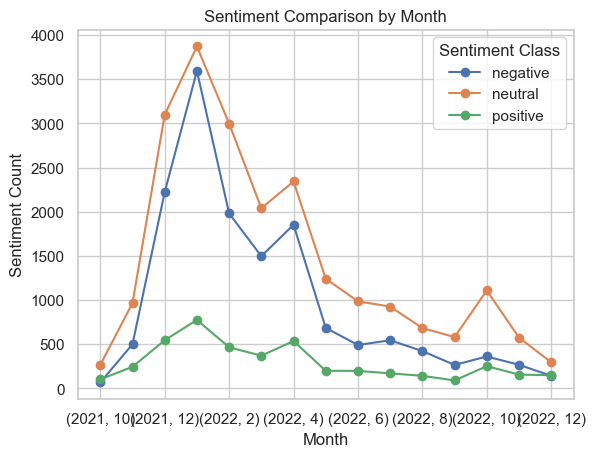

In [57]:
# Read the dataset into a pandas DataFrame
df = pd.read_csv('../Cleaning/Clean_Dataset.csv')

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date_created'], format='%Y/%m/%d')

# Group the data by month and sentiment class and count the occurrences
grouped_data = df.groupby([df['date'].dt.year, df['date'].dt.month, 'indonlp_sentiment']).size().unstack(fill_value=0)

# Plot the line chart
grouped_data.plot(kind='line', marker='o')

# Customize the chart
plt.xlabel('Month')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Comparison by Month')
plt.legend(title='Sentiment Class')

# Display the chart
plt.show()
